<a href="https://colab.research.google.com/github/taeyoonnoh/Grand-Heart-Project/blob/main/Autoencoder_Colab/grand_heart_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import pandas as pd
from difflib import SequenceMatcher
import os

In [ ]:
!unzip KFoods.zip -d Kfoods

In [3]:
# Load images
img_height = 256
img_width = 256
channels = 3
batch_size = 8

train_datagen = ImageDataGenerator(#rotation_range=40,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   rescale=1./255,
                                   #shear_range=0.2,
                                   #zoom_range=0.2,
                                   #horizontal_flip=True,
                                   #fill_mode='nearest',
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(
    '/content/Kfoods',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

validation_set = train_datagen.flow_from_directory(
    '/content/Kfoods',
     target_size = (img_height, img_width),
     batch_size = batch_size,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)

Found 53 images belonging to 1 classes.
Found 13 images belonging to 1 classes.


In [4]:
# Define the autoencoder
input_model = Input(shape=(img_height, img_width, channels))

# Encoder layers
encoder = Conv2D(32, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(encoder)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder = Conv2D(64, (3,3), padding='same', kernel_initializer='normal')(input_model)
encoder = LeakyReLU()(encoder)
encoder = BatchNormalization(axis=-1)(encoder)

encoder_dim = K.int_shape(encoder)
encoder = Flatten()(encoder)

# Latent Space
latent_space = Dense(16, name='latent_space')(encoder)

# Decoder Layers
decoder = Dense(np.prod(encoder_dim[1:]))(latent_space)
decoder = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(decoder)
decoder = LeakyReLU()(decoder)
decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, (3, 3), padding="same")(decoder)
output = Activation('sigmoid', name='decoder')(decoder)

# Create model object
autoencoder = Model(input_model, output, name='autoencoder')

# Model Summary
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
flatten (Flatten)            (None, 4194304)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                67108880  
_________________________________________________________________
dense (Dense)                (None, 4194304)           

In [5]:
# Compile the model
autoencoder.compile(loss="mse", optimizer= Adam(learning_rate=1e-3))

checkpoint = ModelCheckpoint('image_autoencoder_2.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    mode='auto'
)

# Fit the model
history = autoencoder.fit_generator(
          training_set,
          steps_per_epoch=training_set.n // batch_size,
          epochs=100,
          validation_data=validation_set,
          validation_steps=validation_set.n // batch_size,
          callbacks = [checkpoint,early_stopping])

# Save model
#autoencoder.save('models/image_autoencoder_2.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


6/6 [==============================] - 58s 9s/step - loss: 0.1265 - val_loss: 0.2282
Epoch 2/100
6/6 [==============================] - 56s 9s/step - loss: 0.0802 - val_loss: 0.1849
Epoch 3/100
6/6 [==============================] - 56s 9s/step - loss: 0.0720 - val_loss: 0.1511
Epoch 4/100
6/6 [==============================] - 56s 9s/step - loss: 0.0634 - val_loss: 0.1361
Epoch 5/100
6/6 [==============================] - 56s 9s/step - loss: 0.0593 - val_loss: 0.1085
Epoch 6/100
6/6 [==============================] - 58s 9s/step - loss: 0.0616 - val_loss: 0.1023
Epoch 7/100
6/6 [==============================] - 60s 10s/step - loss: 0.0574 - val_loss: 0.0854
Epoch 8/100
6/6 [==============================] - 57s 9s/step - loss: 0.0542 - val_loss: 0.0804
Epoch 9/100
6/6 [==============================] - 59s 10s/step - loss: 0.0517 - val_loss: 0.0751
Epoch 10/100
6/6 [==============================] - 56s 9s/step - loss: 0.0502 - val_loss: 0.0756
Epoch 11/100
6/6 [=====================

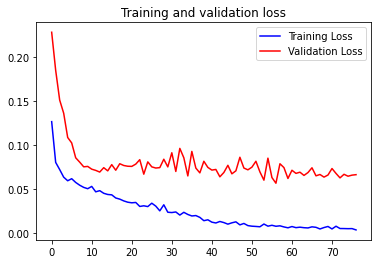

In [6]:
# Plot Accuracy and Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(loss))
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [7]:
# Predict image function
def predict_image(image_dir, autoencoder):
  raw_image = load_img(image_dir, target_size=(256, 256))
  image = img_to_array(raw_image)
  image = np.expand_dims(image, axis=0)
  image = image / 255.0
  pred = autoencoder.predict(image)
  pred = pred * 255.0
  pred = np.reshape(pred, (256, 256, 3))
  pred = array_to_img(pred)

  return raw_image, pred

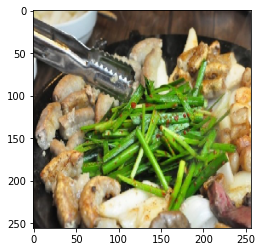

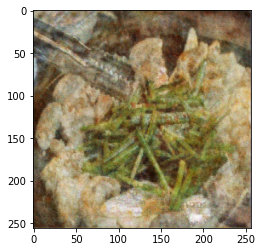

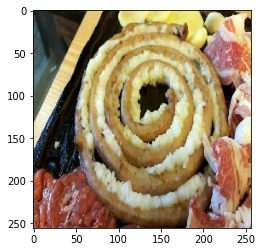

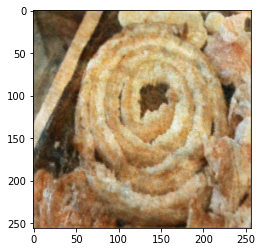

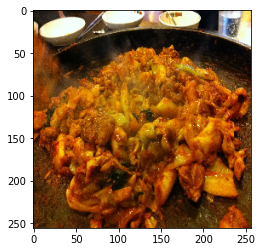

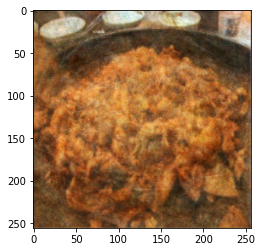

In [8]:
# Predict 3 images from training set
train_imgs = training_set.filepaths[0:3]

for i in train_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

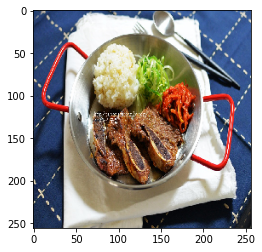

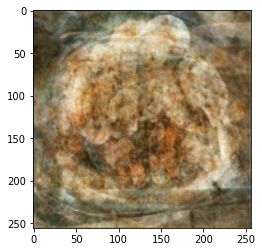

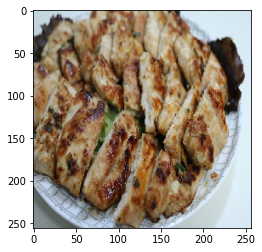

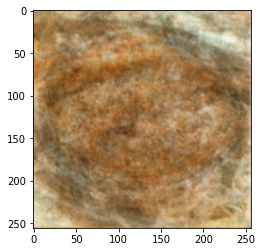

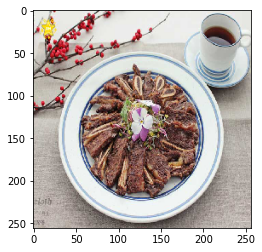

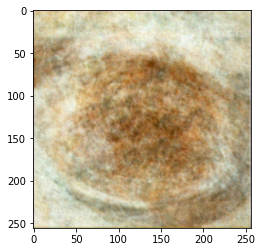

In [9]:
# Predict 3 images from validation set
val_imgs = validation_set.filepaths[0:3]

for i in val_imgs:
  raw_image, pred_image = predict_image(i, autoencoder)
  
  # Show original image
  plt.imshow(raw_image)
  plt.show()
  
  # Show predicted image
  plt.imshow(pred_image)
  plt.show()

In [10]:
# Create model with latent space layer
autoencoder = load_model('image_autoencoder_2.h5', compile=False)
latent_space_model = Model(autoencoder.input, autoencoder.get_layer('latent_space').output)

In [15]:
# Load all images and predict them with the latent space model
X = []
indices = []

for i in tqdm(range(len(os.listdir('/content/Kfoods/Foods')))):
  try:
    img_name = os.listdir('/content/Kfoods/Foods')[i]
    img = load_img('/content/Kfoods/Foods/{}'.format(img_name), target_size = (256, 256))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    pred = latent_space_model.predict(img)
    pred = np.resize(pred, (16))
    X.append(pred)
    indices.append(img_name)

    # Export the embeddings
    if i in [1,10,100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,12000,13000,14000,15000,16000,17000,18000,19000]:
      embeddings = {'indices': indices, 'features': np.array(X)}

      pickle.dump(embeddings, open('/content/Kfoods/image_embeddings_2.pickle', 'wb'))

  except:
    print(img_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


In [17]:
# Export the embeddings
embeddings = {'indices': indices, 'features': np.array(X)}

pickle.dump(embeddings, open('/content/Kfoods/image_embeddings_2.pickle', 'wb'))

In [18]:
def eucledian_distance(x,y):
  eucl_dist = np.linalg.norm(x - y)
  return eucl_dist

def category_similarity(x,y):
  return SequenceMatcher(None, x, y).ratio()

In [21]:
# Load embeddings
embeddings = pickle.load(open('/content/Kfoods/image_embeddings_2.pickle', 'rb'))

# Load images metadata
# metadata = pd.read_csv('flipkart/metadata.csv')

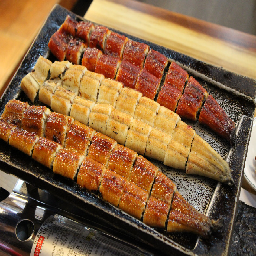

In [26]:
# Get image name
img_name = os.listdir('/content/Kfoods/Foods')[3]
img = load_img('/content/Kfoods/Foods/{}'.format(img_name), target_size=(256, 256))
img

In [27]:
img_name

'장어구이2.jpg'

In [28]:
# Calculate eucledian distance
img_similarity = []
cat_similarity = []

# Get actual image embedding
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)
pred = latent_space_model.predict(img)
pred = np.resize(pred, (16))
# img_cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
img_cat = '장어구이2'
print(f'Image Category: {img_cat}')

Image Category: 장어구이2


In [24]:
embeddings['indices'][0]

'시래기국3.JPG'

In [29]:
for i in tqdm(range(len(embeddings['indices']))):
  img_name = embeddings['indices'][i]

  # Calculate vectors distances
  dist = eucledian_distance(pred,embeddings['features'][i])
  img_similarity.append(dist)

  # Calculate categoy similarity
  # cat = metadata.query("id == '{}'".format(img_name.replace('.jpg','')))['category'].values[0]
  cat = img_name.replace('.jpg','')
  cat_sim = category_similarity(img_cat, cat)
  cat_similarity.append(cat_sim)

imgs_result = pd.DataFrame({'img': embeddings['indices'],
                            'euclidean_distance': img_similarity,
                            'category_similarity': cat_similarity})


imgs_result = imgs_result.query('euclidean_distance > 0').sort_values(by='euclidean_distance', ascending=True).reset_index(drop=True)
imgs_result = imgs_result.iloc[0:20,:].sort_values(by='category_similarity', ascending=False).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [30]:
imgs_result

,img,euclidean_distance,category_similarity
0,황태구이2.jpg,3020.423828,0.600000
1,갈비구이2.jpg,3300.141602,0.600000
2,조개구이2.jpg,3322.570801,0.600000
3,고등어구이1.jpg,2893.027588,0.545455
4,육개장2.jpg,3011.511475,0.444444
5,갈치구이1.jpg,3274.780762,0.400000
6,갈비구이1.jpg,3157.498291,0.400000
7,닭갈비2.jpg,3300.371826,0.222222
8,육개장1.jpg,2528.478271,0.222222
9,계란국2.jpg,2835.812256,0.222222


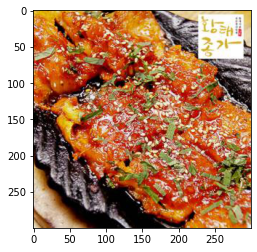

Image Category: 황태구이2
Euclidean Distance: 3020.423828125
Category Distance: 0.6


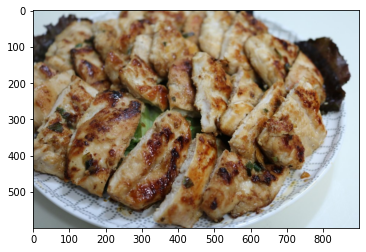

Image Category: 갈비구이2
Euclidean Distance: 3300.1416015625
Category Distance: 0.6


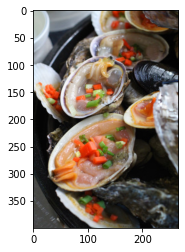

Image Category: 조개구이2
Euclidean Distance: 3322.57080078125
Category Distance: 0.6


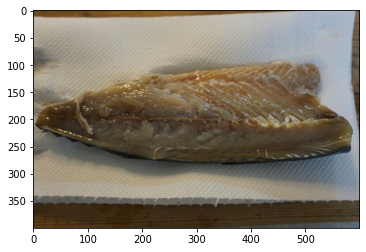

Image Category: 고등어구이1
Euclidean Distance: 2893.027587890625
Category Distance: 0.5454545454545454


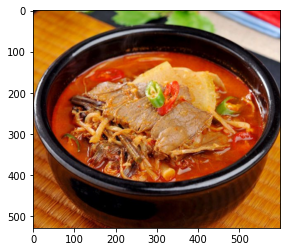

Image Category: 육개장2
Euclidean Distance: 3011.511474609375
Category Distance: 0.4444444444444444


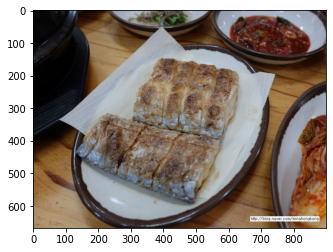

Image Category: 갈치구이1
Euclidean Distance: 3274.78076171875
Category Distance: 0.4


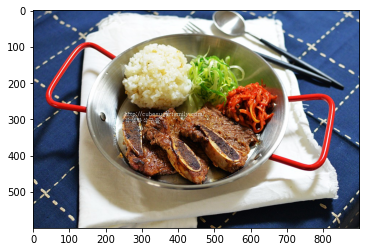

Image Category: 갈비구이1
Euclidean Distance: 3157.498291015625
Category Distance: 0.4


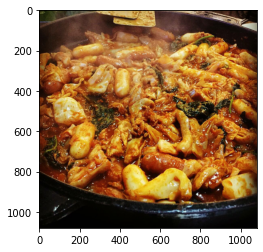

Image Category: 닭갈비2
Euclidean Distance: 3300.371826171875
Category Distance: 0.2222222222222222


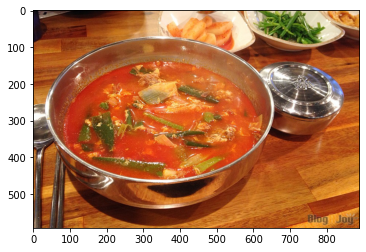

Image Category: 육개장1
Euclidean Distance: 2528.478271484375
Category Distance: 0.2222222222222222


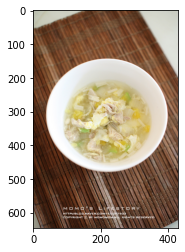

Image Category: 계란국2
Euclidean Distance: 2835.812255859375
Category Distance: 0.2222222222222222


In [31]:
# Show 10 first similar images
for i in range(10):
  image = load_img('/content/Kfoods/Foods/{}'.format(imgs_result['img'].values[i]))
  # category = metadata.query("id == '{}'".format(imgs_result['img'].values[i].replace('.jpg','')))['category'].values[0]
  category = imgs_result['img'].values[i].replace('.jpg','')

  # Show image
  plt.imshow(image)
  plt.show()
  print('Image Category: {}'.format(category))
  print('Euclidean Distance: {}'.format(imgs_result['euclidean_distance'].values[i]))
  print('Category Distance: {}'.format(imgs_result['category_similarity'].values[i]))

In [32]:
imgs_result

,img,euclidean_distance,category_similarity
0,황태구이2.jpg,3020.423828,0.600000
1,갈비구이2.jpg,3300.141602,0.600000
2,조개구이2.jpg,3322.570801,0.600000
3,고등어구이1.jpg,2893.027588,0.545455
4,육개장2.jpg,3011.511475,0.444444
5,갈치구이1.jpg,3274.780762,0.400000
6,갈비구이1.jpg,3157.498291,0.400000
7,닭갈비2.jpg,3300.371826,0.222222
8,육개장1.jpg,2528.478271,0.222222
9,계란국2.jpg,2835.812256,0.222222
